In [1]:
!pip install tensorflow==2.1.0

In [2]:
!pip install tensorflow_probability==0.8.0

In [0]:
import numpy as np
import urllib
import os
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, Input, Concatenate
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers
tfd = tfp.distributions


In [4]:
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.8.0
TF  Version 2.1.0


In [0]:
if not os.path.isfile('X_faces.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/5m7nmebpjysqtus/X_faces.npy?dl=1",
    "X_faces.npy")

if not os.path.isfile('Y_age.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/flpyvgdqoatdw0g/Y_age.npy?dl=1",
    "Y_age.npy")


In [0]:
X=np.load("X_faces.npy")
Y=np.load("Y_age.npy")

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=201)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=34)

In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


In [0]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255

In [0]:
X_train = np.array(X_train,dtype="float32")
X_val = np.array(X_val,dtype="float32")
X_test = np.array(X_test,dtype="float32")

y_train = np.array(y_train,dtype="float32")
y_val = np.array(y_val,dtype="float32")
y_test = np.array(y_test,dtype="float32")

In [0]:
kernel_size = (3, 3)
pool_size = (2, 2)

In [0]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

input1 = Input(shape=(80,80,3))
input2 = Input(shape=(1,))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(input1)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.3)(x)
out1 = Dense(1)(x)
out2 = Dense(1)(input2) 
params = Concatenate()([out1,out2]) 
dist = tfp.layers.DistributionLambda(my_dist)(params) #

model_const_sd = Model(inputs=[input1,input2], outputs=dist) ## use a trick with two inputs, input2 is just ones
model_const_sd.compile(tf.keras.optimizers.Adam(), loss=NLL) 

In [13]:
# train the model
history=model_const_sd.fit([X_train,np.expand_dims(np.ones(len(X_train)),1)], y_train, 
                    batch_size=128, 
                    epochs=40,
                    verbose=1, 
                    validation_data=([X_val,np.expand_dims(np.ones(len(X_val)),1)], y_val)
                  )


Train on 10642 samples, validate on 5242 samples
Epoch 1/40
10642/10642 [==============================] - 7s 621us/sample - loss: 608.6425 - val_loss: 462.4419
Epoch 2/40
10642/10642 [==============================] - 4s 380us/sample - loss: 474.5536 - val_loss: 426.0513
Epoch 3/40
10642/10642 [==============================] - 4s 385us/sample - loss: 415.6929 - val_loss: 324.5497
Epoch 4/40
10642/10642 [==============================] - 4s 387us/sample - loss: 307.4994 - val_loss: 238.8736
Epoch 5/40
10642/10642 [==============================] - 4s 381us/sample - loss: 253.2638 - val_loss: 224.5671
Epoch 6/40
10642/10642 [==============================] - 4s 380us/sample - loss: 236.4223 - val_loss: 195.4973
Epoch 7/40
10642/10642 [==============================] - 4s 381us/sample - loss: 217.2396 - val_loss: 164.5242
Epoch 8/40
10642/10642 [==============================] - 4s 384us/sample - loss: 195.3251 - val_loss: 146.9104
Epoch 9/40
10642/10642 [==============================]

In [0]:
model_const_sd_mean = Model(inputs=[input1,input2], outputs=dist.mean())
model_const_sd_sd = Model(inputs=[input1,input2], outputs=dist.stddev())

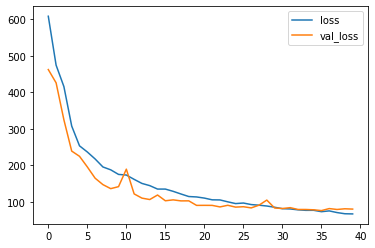

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

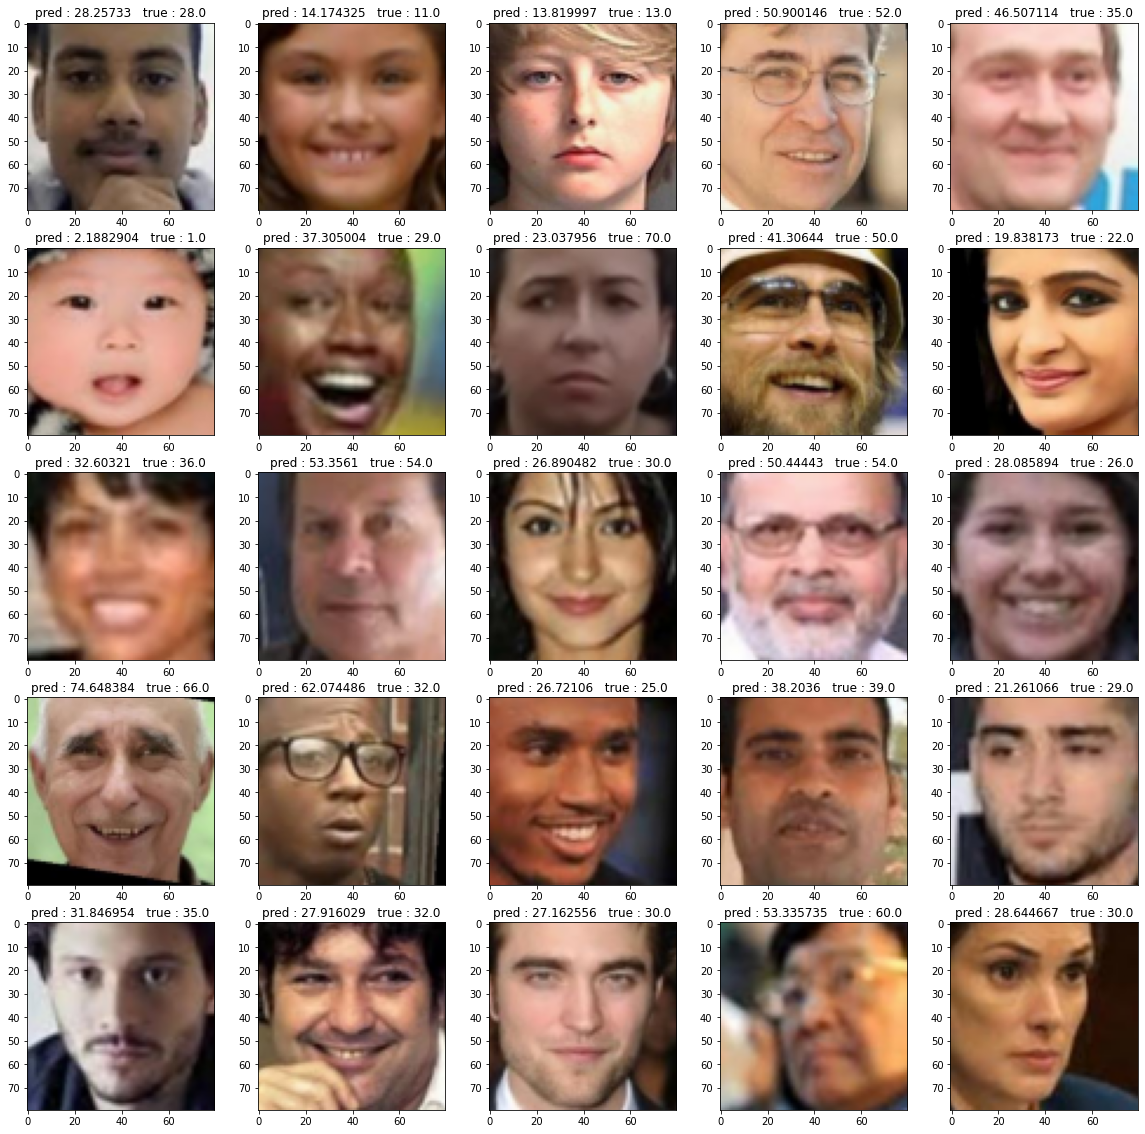

In [16]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title("pred : "+ np.str(model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)])[0][0]) + "   true : "+ np.str(y_test[i]))

[[28.25733]]
[[0.7835859]]


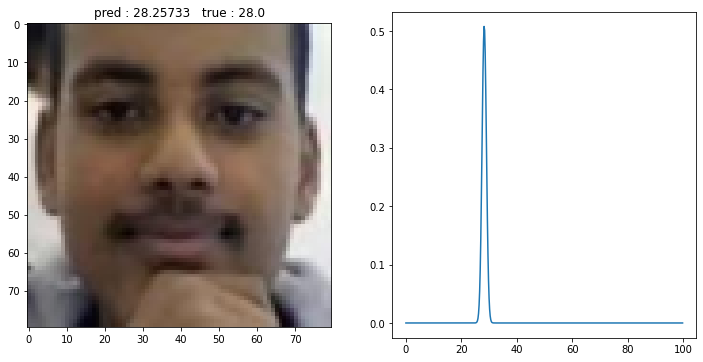

[[14.174325]]
[[0.7835859]]


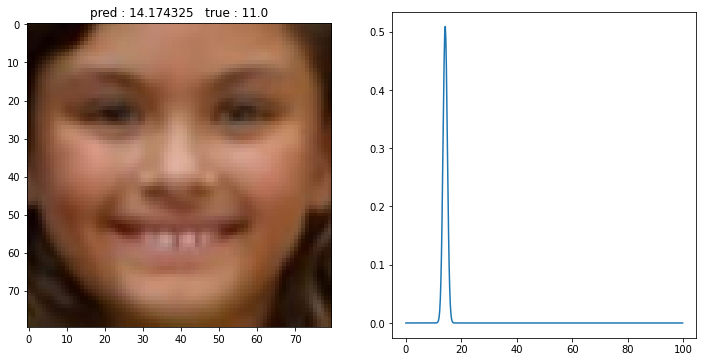

[[13.819997]]
[[0.7835859]]


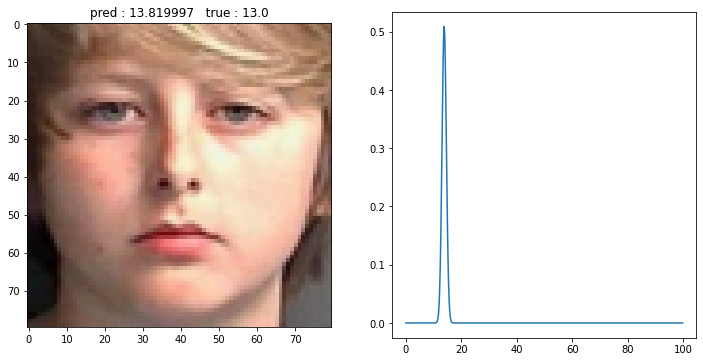

[[50.900146]]
[[0.7835859]]


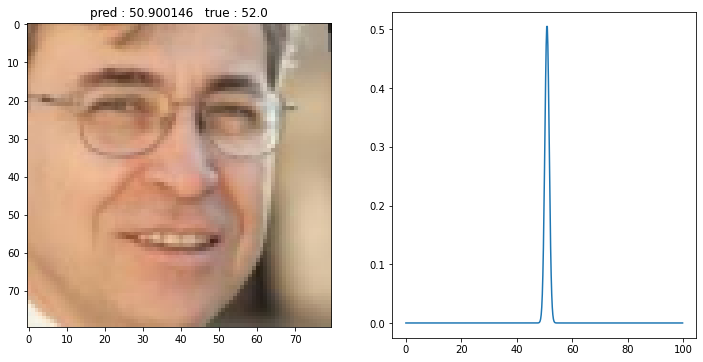

[[46.507114]]
[[0.7835859]]


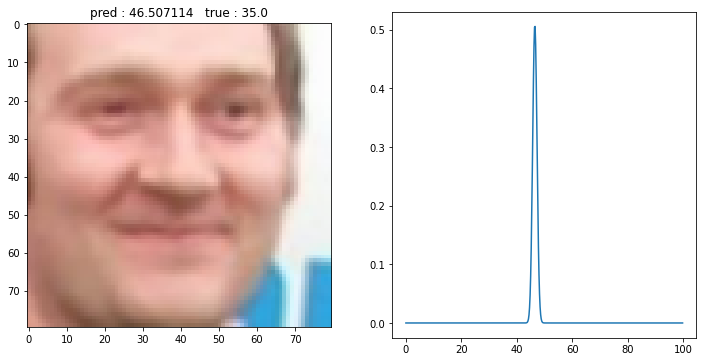

[[2.1882904]]
[[0.7835859]]


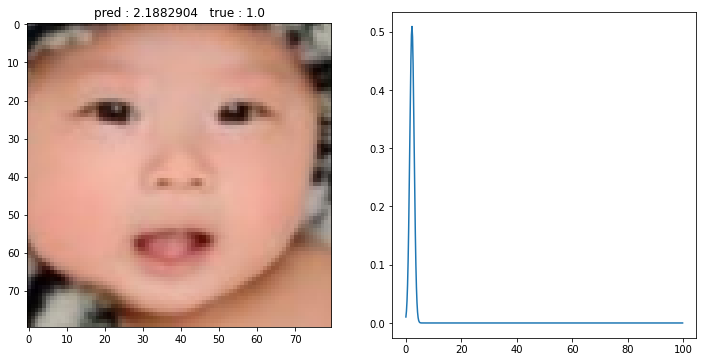

[[37.305004]]
[[0.7835859]]


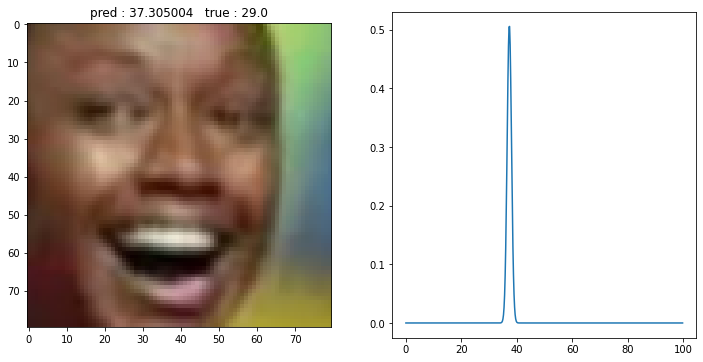

[[23.037956]]
[[0.7835859]]


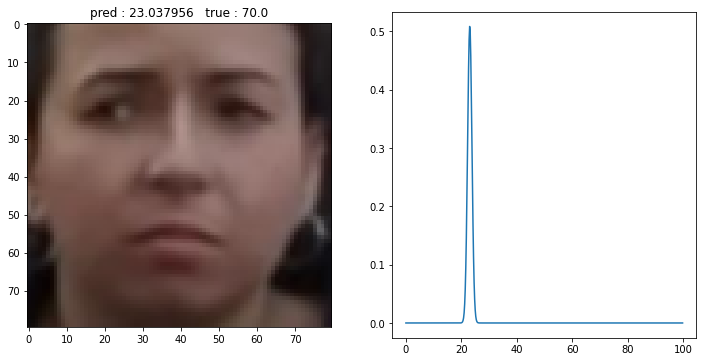

[[41.30644]]
[[0.7835859]]


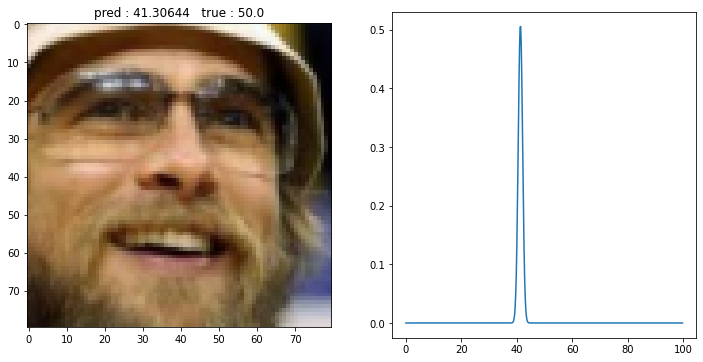

[[19.838173]]
[[0.7835859]]


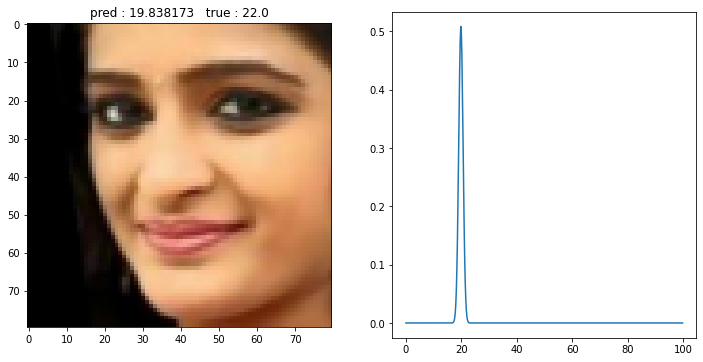

In [17]:
for i in range(0,10):
  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.imshow(X_test[i])
  plt.title("pred : "+ np.str(model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)])[0][0]) + "   true : "+ np.str(y_test[i]))
  print(model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]))
  print(model_const_sd_sd.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]))
  d = tfd.Normal(loc=model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]), scale=model_const_sd_sd.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]))           #A
  plt.subplot(1,2,2)
  plt.plot(np.arange(0,100,0.2),d.prob(np.arange(0,100,0.2))[0])
  plt.show()

In [0]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(80,80,3))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(inputs)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(2)(x)
dist = tfp.layers.DistributionLambda(my_dist)(x) 

model_flex = Model(inputs=inputs, outputs=dist)
model_flex.compile(tf.keras.optimizers.Adam(), loss=NLL) 


In [19]:
# train the model
history=model_flex.fit(X_train, np.array(y_train,dtype="float32"), 
                  batch_size=32, 
                  epochs=40,
                  verbose=1, 
                  validation_data=(X_val, np.array(y_val,dtype="float32")))


Train on 10642 samples, validate on 5242 samples
Epoch 1/40
10642/10642 [==============================] - 6s 591us/sample - loss: 21.6257 - val_loss: 4.5695
Epoch 2/40
10642/10642 [==============================] - 5s 509us/sample - loss: 4.7583 - val_loss: 4.4957
Epoch 3/40
10642/10642 [==============================] - 5s 509us/sample - loss: 4.6346 - val_loss: 4.4698
Epoch 4/40
10642/10642 [==============================] - 5s 506us/sample - loss: 4.6591 - val_loss: 4.4502
Epoch 5/40
10642/10642 [==============================] - 5s 516us/sample - loss: 4.6003 - val_loss: 4.4380
Epoch 6/40
10642/10642 [==============================] - 5s 509us/sample - loss: 4.5277 - val_loss: 4.3444
Epoch 7/40
10642/10642 [==============================] - 5s 512us/sample - loss: 4.4894 - val_loss: 4.2619
Epoch 8/40
10642/10642 [==============================] - 5s 509us/sample - loss: 4.4505 - val_loss: 4.3276
Epoch 9/40
10642/10642 [==============================] - 5s 507us/sample - loss: 4.46

In [0]:
model_mean = Model(inputs=inputs, outputs=dist.mean())
model_sd = Model(inputs=inputs, outputs=dist.stddev())

In [21]:
model_flex.evaluate(X_train,y_train,verbose=0)

3.328232334243066

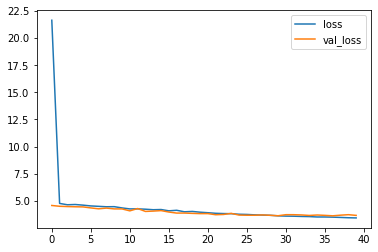

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

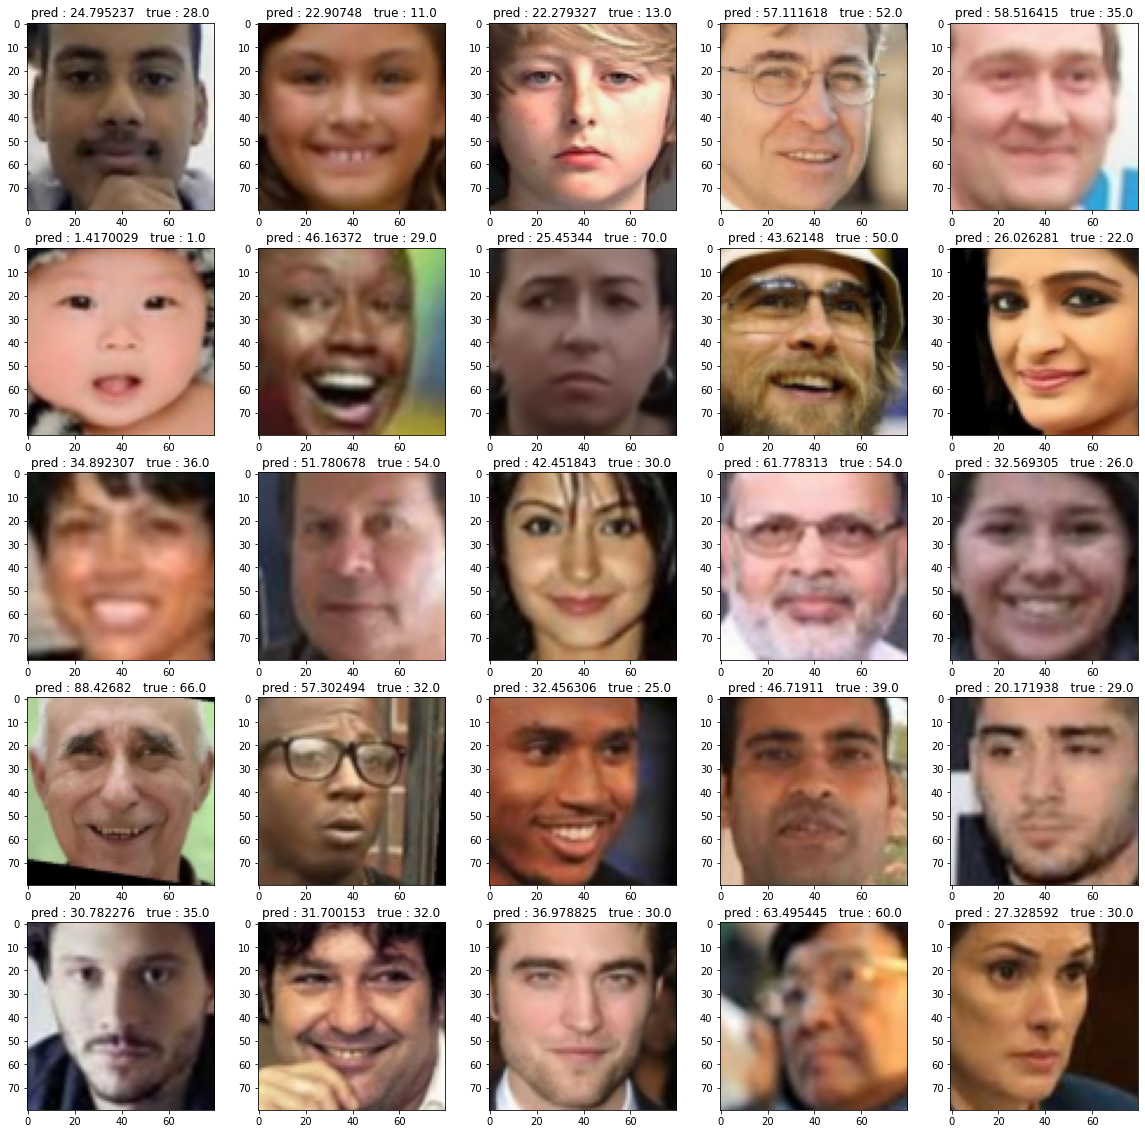

In [23]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title("pred : "+ np.str(model_mean.predict(X_test[i:i+1])[0][0]) + "   true : "+ np.str(y_test[i]))

[[24.795237]]
[[6.398729]]


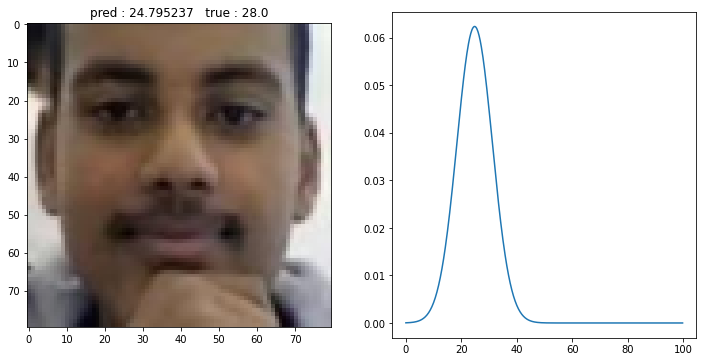

[[22.90748]]
[[6.6537066]]


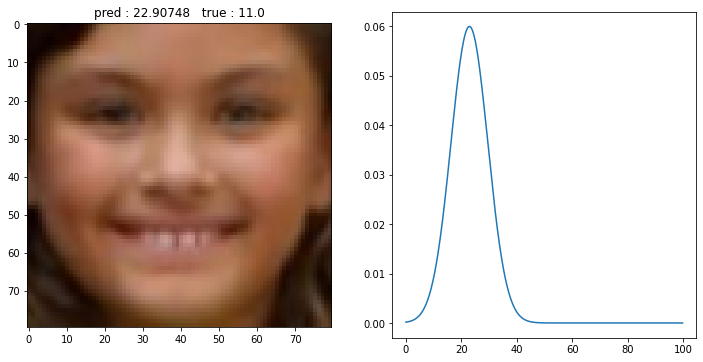

[[22.279327]]
[[6.60255]]


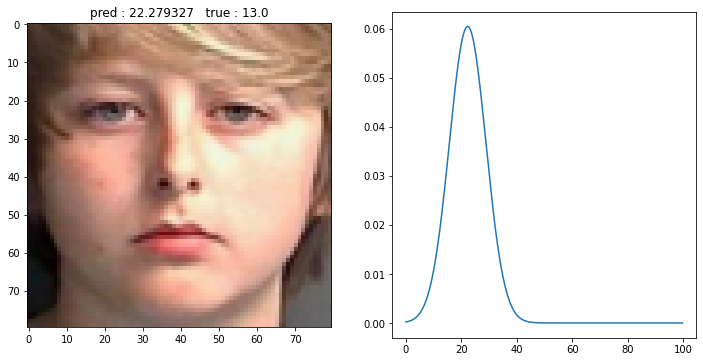

[[57.111618]]
[[15.496944]]


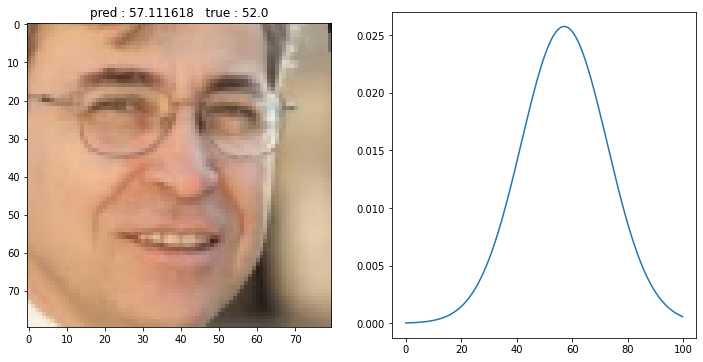

[[58.516415]]
[[16.083364]]


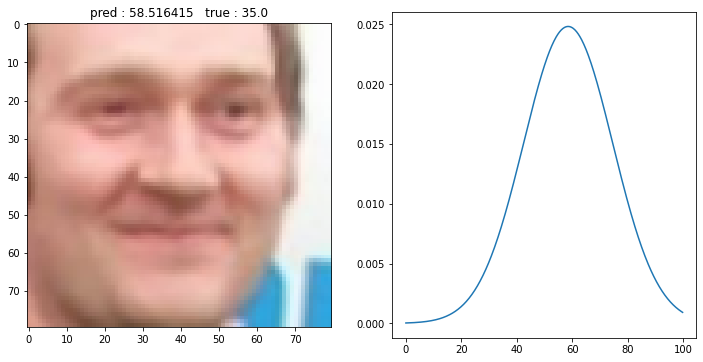

[[1.4170029]]
[[0.5728403]]


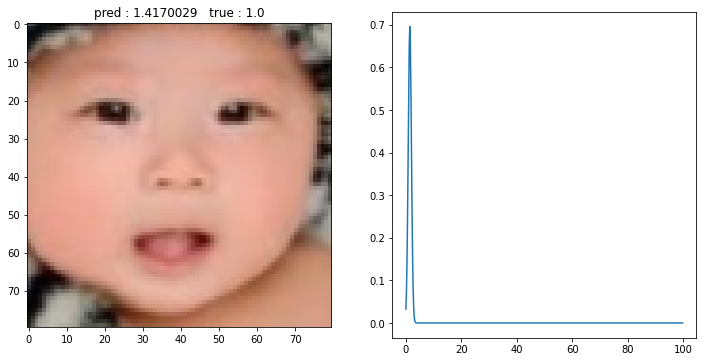

[[46.16372]]
[[13.592556]]


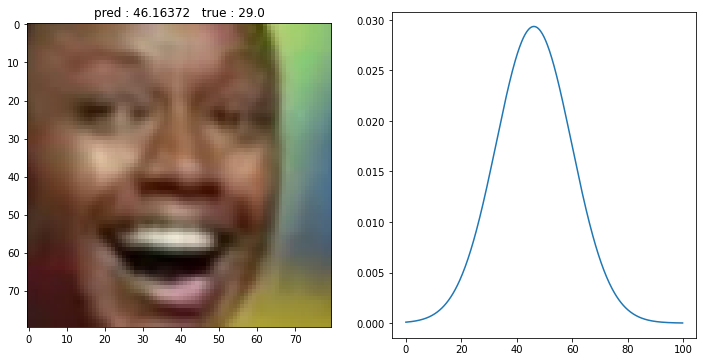

[[25.45344]]
[[6.751568]]


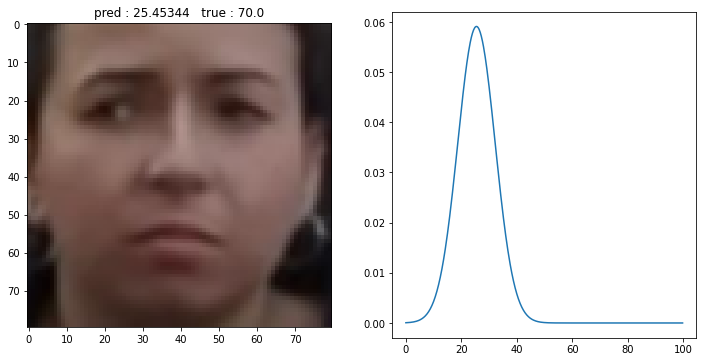

[[43.62148]]
[[11.875297]]


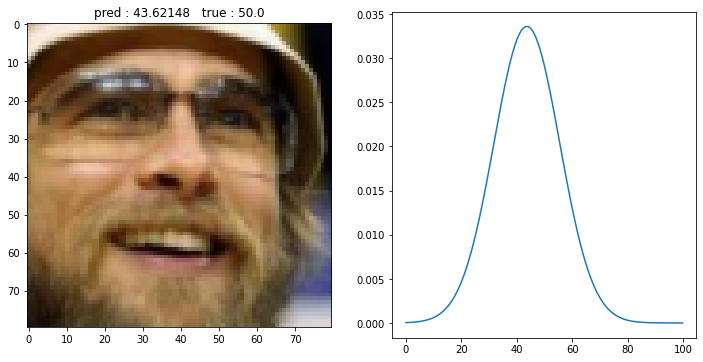

[[26.026281]]
[[7.0813727]]


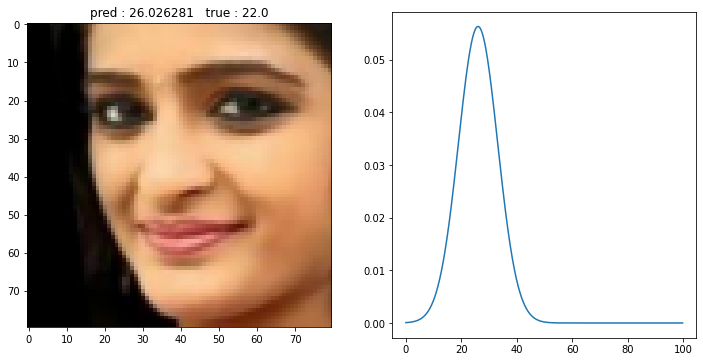

In [24]:
for i in range(0,10):
  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.imshow(X_test[i])
  plt.title("pred : "+ np.str(model_mean.predict(X_test[i:i+1])[0][0]) + "   true : "+ np.str(y_test[i]))
  print(model_mean.predict(X_test[i:i+1]))
  print(model_sd.predict(X_test[i:i+1]))
  d = tfd.Normal(loc=model_mean.predict(X_test[i:i+1]), scale=model_sd.predict(X_test[i:i+1]))           #A
  plt.subplot(1,2,2)
  plt.plot(np.arange(0,100,0.2),d.prob(np.arange(0,100,0.2))[0])
  plt.show()